# ML for AIR

In [31]:
import pandas as pd
import numpy as np
import string as str
from datetime import datetime
import sys
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from autots import AutoTS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
#from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
path = r"D:\OneDrive - Wipro\Desktop\AIR\\"
infile =  path + "AIR_WDC_today_Q325.csv"

#table = pd.read_csv(infile, engine='python',sep=',', quotechar='"', error_bad_lines=False)

table_chunk = pd.read_csv(infile, engine='python', sep=',', chunksize=2000000)
table = pd.concat(list(table_chunk))

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

table.head()

,LOAD_DATE,SR_GUID,PROJECT_NUMBER,PROJECT_NAME,PROJECT_DESCRIPTION,CUSTOMER_NO,CUSTOMER_NAME,INDENT_STATUS,PROJECT_PROFIT_CENTER,PROJECT_PROFIT_CENTER_DESCRIPTION,...,SL_OPS_PC_CODE,SL_OPS_GBL,SL_OPS_SERVICE_LINE,SLWBS,SL_DM_ID,SL_DM_NAME,SL_PM_ID,SL_PM_NAME,SOW_OWNER_EMAIL,REPORT_TIME
0,2025-02-21,0DB01716A8EF1EDFA08132AD9644FEF8,605170,73063/P03/B99/S61,73063/P03/B99SO00000035-PR2024K0936561,2.252900e+04,HSBC Software Delvelopment India Pv,RECRUIT,PC34100,EUROPE,...,PC53000,WIPRO FULLSTRIDE CLOUD,FSC - WDC,73063/P03/B99/SL01,131690.0,Pravin Ranglalji Mantri,20388183.0,Smita Sarwate,pravin.mantri@wipro.com,21-FEB-2025 01:14:29
1,2025-02-21,0DB01716A8EF1EDFA0C88DE701443F80,55674,INS-NOR-PJ-RPA_DEV,INS-NWM-PJ- RPA DEV,2.024000e+03,Northwestern Mutual,RECRUIT,PC32900,AMERICAS 2,...,PC53000,WIPRO FULLSTRIDE CLOUD,FSC - WDC,127604_USD/SL04,165191.0,Vijay Anand Viswanathan,300109.0,Kasirajesh Venkitakrishnan,vijay.vishwanathan@wipro.com,21-FEB-2025 01:14:29
2,2025-02-21,0DB01716A8EF1EDFA0B07C527A5D5F62,607431,73502/P03/B99/S56-1,73502/P03/B99SO00000158-PR2024K09391156,6.427000e+03,"Ross Dress For Less, Inc.",INTERNAL,PC30300,AMERICAS 1,...,PC53000,WIPRO FULLSTRIDE CLOUD,FSC - WDC,73502/P03/B99/SL01,98788.0,Shyam Prasad Vidyala Naga,262221.0,Ashwin Kumar S,vidyala.shyam@wipro.com,21-FEB-2025 01:14:29
3,2025-02-21,0DB01716A8EF1EDFA18F6A4ADD669FB4,607092,38042/P05/B07/S35,CIT-CIT-PJ-ICG-TTS-CC-FPC,1.985700e+04,"Citigroup Technology, Inc",RECRUIT,PC32100,AMERICAS 2,...,PC53000,WIPRO FULLSTRIDE CLOUD,FSC - WDC,NaN,NaN,NaN,NaN,NaN,vikas.gupta@wipro.com,21-FEB-2025 01:14:29
4,2025-02-21,0DB01716A8EF1EDFA1DD637D0B33FFE8,453943,69880/P03/B99/S80,69880/P03/B99SO00000035-PR2024K06261180,1.100041e+09,The Depository Trust Clearing,INTERNAL,PC32900,AMERICAS 2,...,PC53000,WIPRO FULLSTRIDE CLOUD,FSC - WDC,NaN,NaN,NaN,NaN,NaN,ganesan.77@wipro.com,21-FEB-2025 01:14:29


In [ ]:
table.describe()

In [3]:
df = table[['INDENT_CREATED_ON','ESSENTIAL_SKILL','NO_OF_RESOURCES','INDENT_STATE']]

In [4]:
df.head()

,INDENT_CREATED_ON,ESSENTIAL_SKILL,NO_OF_RESOURCES,INDENT_STATE
0,2024-10-01,Fullstack Java Enterprise,1,CANCELLED
1,2024-10-04,Fullstack DevOps,1,FULFILLED
2,2024-10-03,Architecting,1,CANCELLED
3,2024-10-07,Fullstack DevOps,1,CANCELLED
4,2024-10-10,Fullstack Java Enterprise,6,CANCELLED


In [ ]:
df.describe()

In [5]:
df.rename(columns={'INDENT_CREATED_ON': 'Date'}, inplace=True)
df.rename(columns={'NO_OF_RESOURCES': 'Total'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6491 entries, 0 to 6490
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             6491 non-null   object
 1   ESSENTIAL_SKILL  6491 non-null   object
 2   Total            6491 non-null   int64 
 3   INDENT_STATE     6491 non-null   object
dtypes: int64(1), object(3)
memory usage: 203.0+ KB


In [ ]:
df.head()

In [6]:
df['Date'] = pd.to_datetime(df.Date)
#df.head()
#meandf = df['Total'].mean(skipna=True)
#df=df.replace(0,meandf) 
#df['Total'] = df['Total'].replace(['0'],np.average(df['Total']))
df.head()

,Date,ESSENTIAL_SKILL,Total,INDENT_STATE
0,2024-10-01,Fullstack Java Enterprise,1,CANCELLED
1,2024-10-04,Fullstack DevOps,1,FULFILLED
2,2024-10-03,Architecting,1,CANCELLED
3,2024-10-07,Fullstack DevOps,1,CANCELLED
4,2024-10-10,Fullstack Java Enterprise,6,CANCELLED


In [7]:
df.set_index('Date',inplace=True)
df.index

DatetimeIndex(['2024-10-01', '2024-10-04', '2024-10-03', '2024-10-07',
               '2024-10-10', '2024-10-04', '2024-10-03', '2024-10-07',
               '2024-10-11', '2024-10-03',
               ...
               '2024-12-12', '2024-12-12', '2024-12-13', '2024-12-13',
               '2024-12-13', '2024-12-19', '2024-12-19', '2024-12-20',
               '2024-12-21', '2024-12-22'],
              dtype='datetime64[ns]', name='Date', length=6491, freq=None)

In [ ]:
df.asfreq('d').index # Setting the freq of series to Daily 'd'

In [8]:
df = df.groupby("Date").sum()

In [9]:
df = df.sort_index()
df = df['2024-10-01':'2024-12-31'].resample('D').sum()
df.head()

,ESSENTIAL_SKILL,Total,INDENT_STATE
Date,,,
2024-10-01,Fullstack Java Enterprise.NETCore JavaIBM Data...,95,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-10-02,TestingFunctional TestingArchitectingTestingFu...,25,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-10-03,ArchitectingDevOpsJava-J2EEPython Application ...,207,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-10-04,Fullstack DevOpsApp Cloud Development Services...,87,FULFILLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-10-05,MicroservicesMainframeFullstack Java Enterpris...,9,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDF...


In [13]:
tdf = df['Total']# copy of Dataframe
tdf1 = tdf.rolling(window=7).mean()
tdf1 = tdf1.fillna(method='bfill')

In [11]:
tdf.to_csv("test.csv")

In [14]:
tdf.rolling(window=7).mean()
tdf.dropna()
tdf

Date
2024-10-01     95
2024-10-02     25
2024-10-03    207
2024-10-04     87
2024-10-05      9
             ... 
2024-12-27     20
2024-12-28      0
2024-12-29      1
2024-12-30     15
2024-12-31      7
Freq: D, Name: Total, Length: 92, dtype: int64

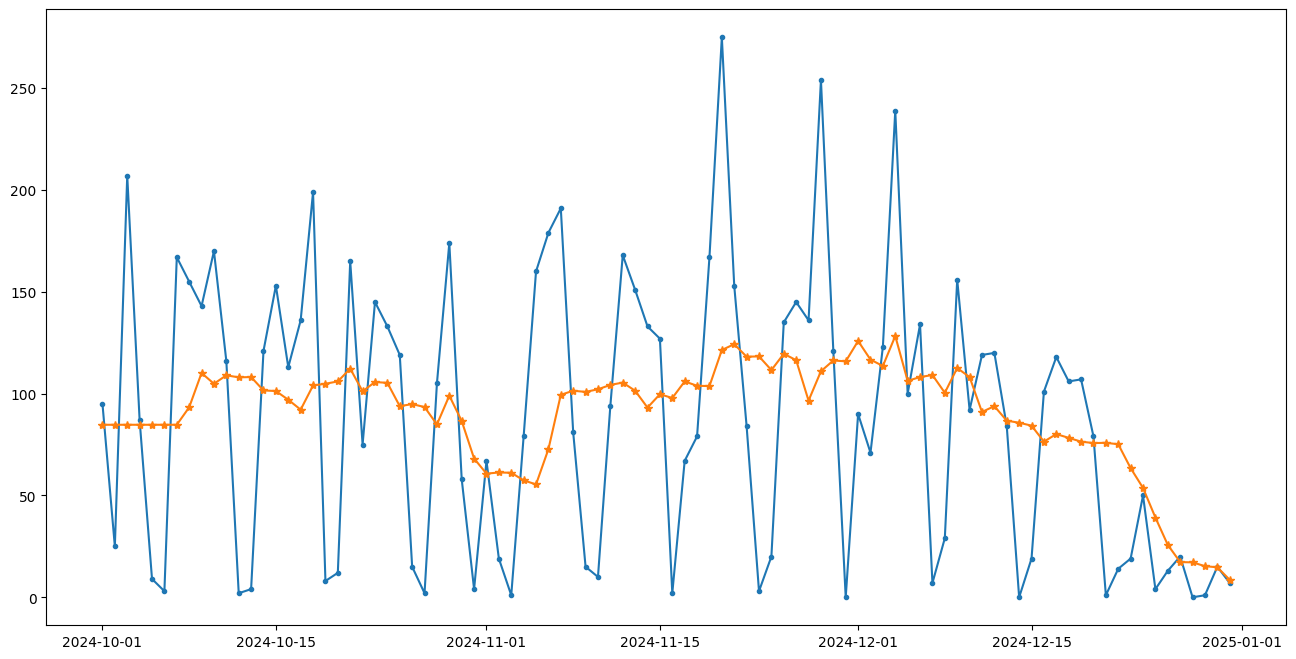

In [15]:
plt.figure(figsize=(16,8))
plt.plot(tdf, label='Open Position Trend', marker='.')
plt.plot(tdf1, marker='*')

In [16]:
def add_features(df):
    df['MA7'] = df['Total'].rolling(window=7).mean()
    df['MA30'] = df['Total'].rolling(window=30).mean()
    df['STD7'] = df['Total'].rolling(window=7).std()
    return df

In [17]:
tdf1 = add_features(df)
tdf1[["Total","MA7","MA30","STD7"]]

,Total,MA7,MA30,STD7
Date,,,,
2024-10-01,95,NaN,NaN,NaN
2024-10-02,25,NaN,NaN,NaN
2024-10-03,207,NaN,NaN,NaN
2024-10-04,87,NaN,NaN,NaN
2024-10-05,9,NaN,NaN,NaN
...,...,...,...,...
2024-12-27,20,17.285714,79.666667,16.080156
2024-12-28,0,17.142857,71.200000,16.252472
2024-12-29,1,15.285714,67.200000,17.375407


In [18]:
# Prepare features and target
def prepare_data(df, lookback=30):
    X = []
    y = []
    for i in range(len(df)-lookback):
        X.append(df[i:(i+lookback)])
        y.append(df[i+lookback])
    return np.array(X), np.array(y)

In [19]:
# Convert your time series data
X, y = prepare_data(tdf.values)

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49, 30), (13, 30), (49,), (13,))

In [34]:

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'GaussianNB': GaussianNB(var_smoothing=1e-3)
    
}

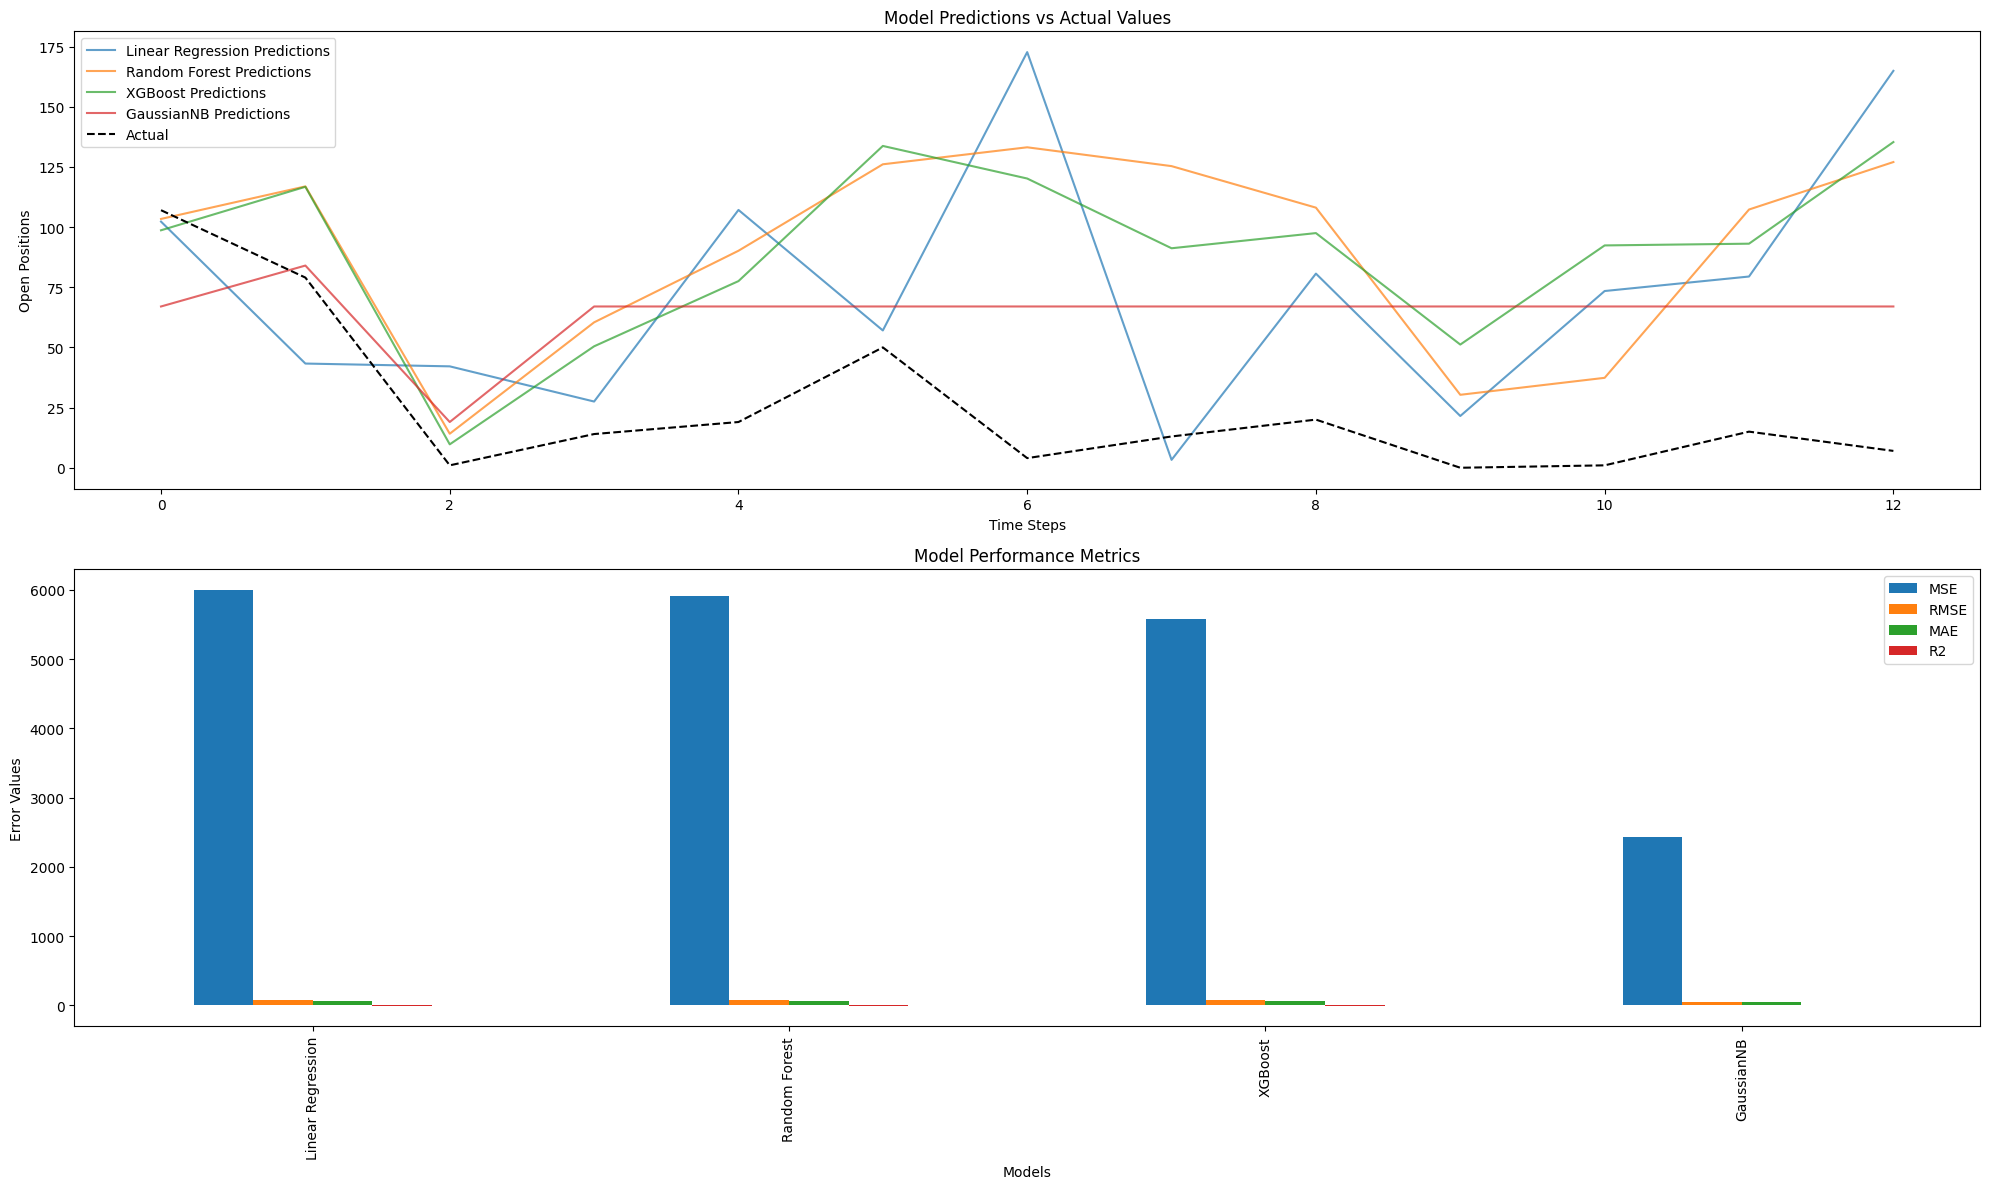

In [35]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate errors
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Plot actual vs predicted for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    ax1.plot(y_pred, label=f'{name} Predictions', alpha=0.7)

ax1.plot(y_test, label='Actual', color='black', linestyle='--')
ax1.set_title('Model Predictions vs Actual Values')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Open Positions')
ax1.legend()

# Plot error metrics
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', ax=ax2)
ax2.set_title('Model Performance Metrics')
ax2.set_xlabel('Models')
ax2.set_ylabel('Error Values')
plt.tight_layout()
plt.show()

In [36]:
# Print detailed results
print("\nDetailed Model Performance Metrics:")
print(pd.DataFrame(results).round(4))


Detailed Model Performance Metrics:
      Linear Regression  Random Forest    XGBoost  GaussianNB
MSE           5999.8631      5909.4881  5574.3604   2430.3077
RMSE            77.4588        76.8732    74.6616     49.2982
MAE             57.3491        65.9031    65.7116     45.3846
R2              -4.8951        -4.8063    -4.4770     -1.3879


In [39]:
forecast_period = 3
def forecast_next_n_months(model, last_sequence, n_steps=forecast_period):
    """
    Forecast the next n months using the trained model
    
    Parameters:
    model: trained model
    last_sequence: last known sequence of data
    n_steps: number of steps to forecast (n months)
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Reshape sequence for prediction
        current_input = current_sequence.reshape(1, -1)
        # Get prediction for next step
        next_pred = model.predict(current_input)[0]
        # Add prediction to results
        predictions.append(next_pred)
        # Update sequence by removing first element and adding prediction
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    return np.array(predictions)


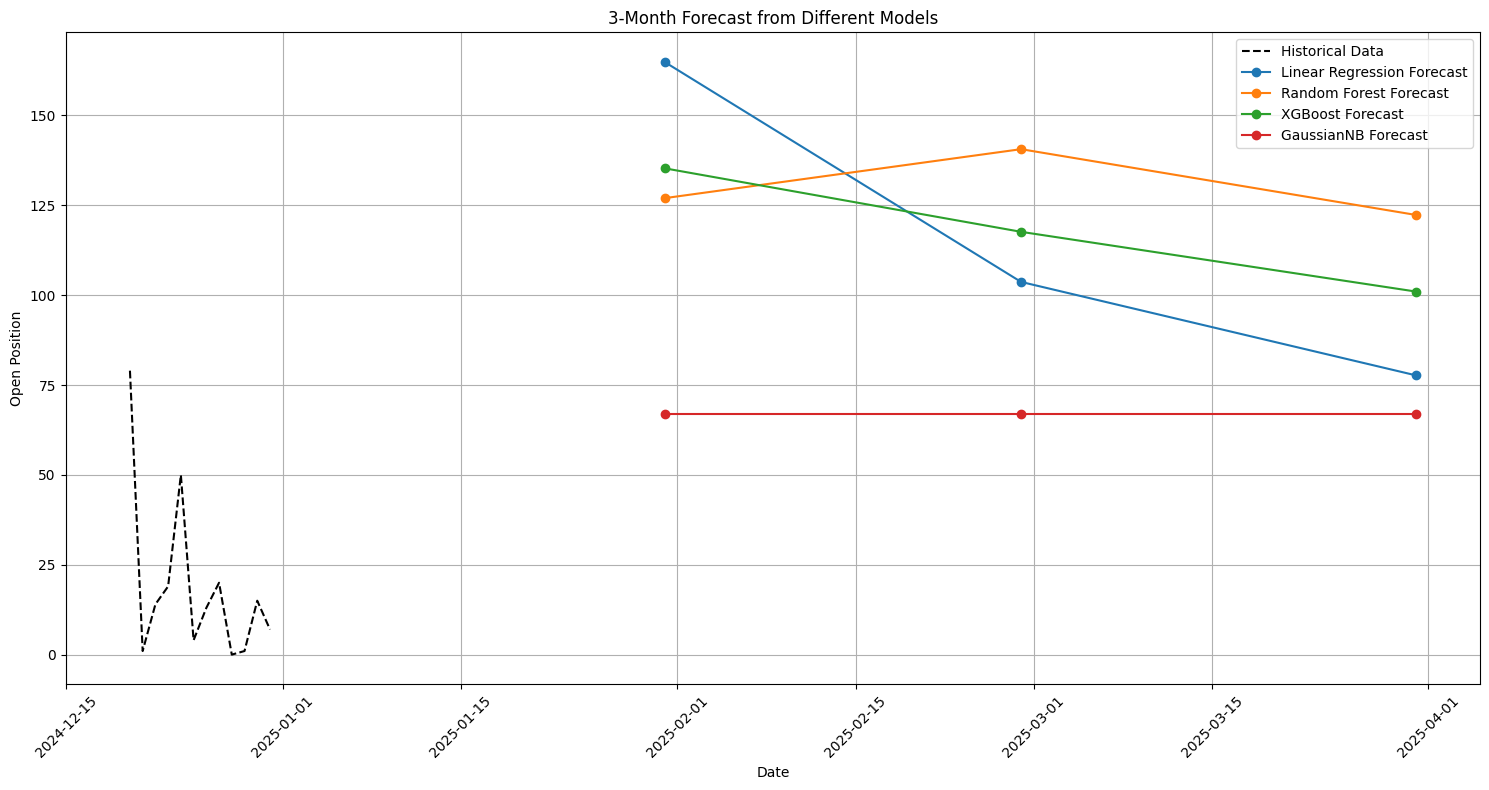


Forecasted values for next 3 months:
            Linear Regression  Random Forest     XGBoost  GaussianNB
2025-01-31             164.89         127.00  135.309998          67
2025-02-28             103.70         140.63  117.629997          67
2025-03-31              77.71         122.34  101.019997          67


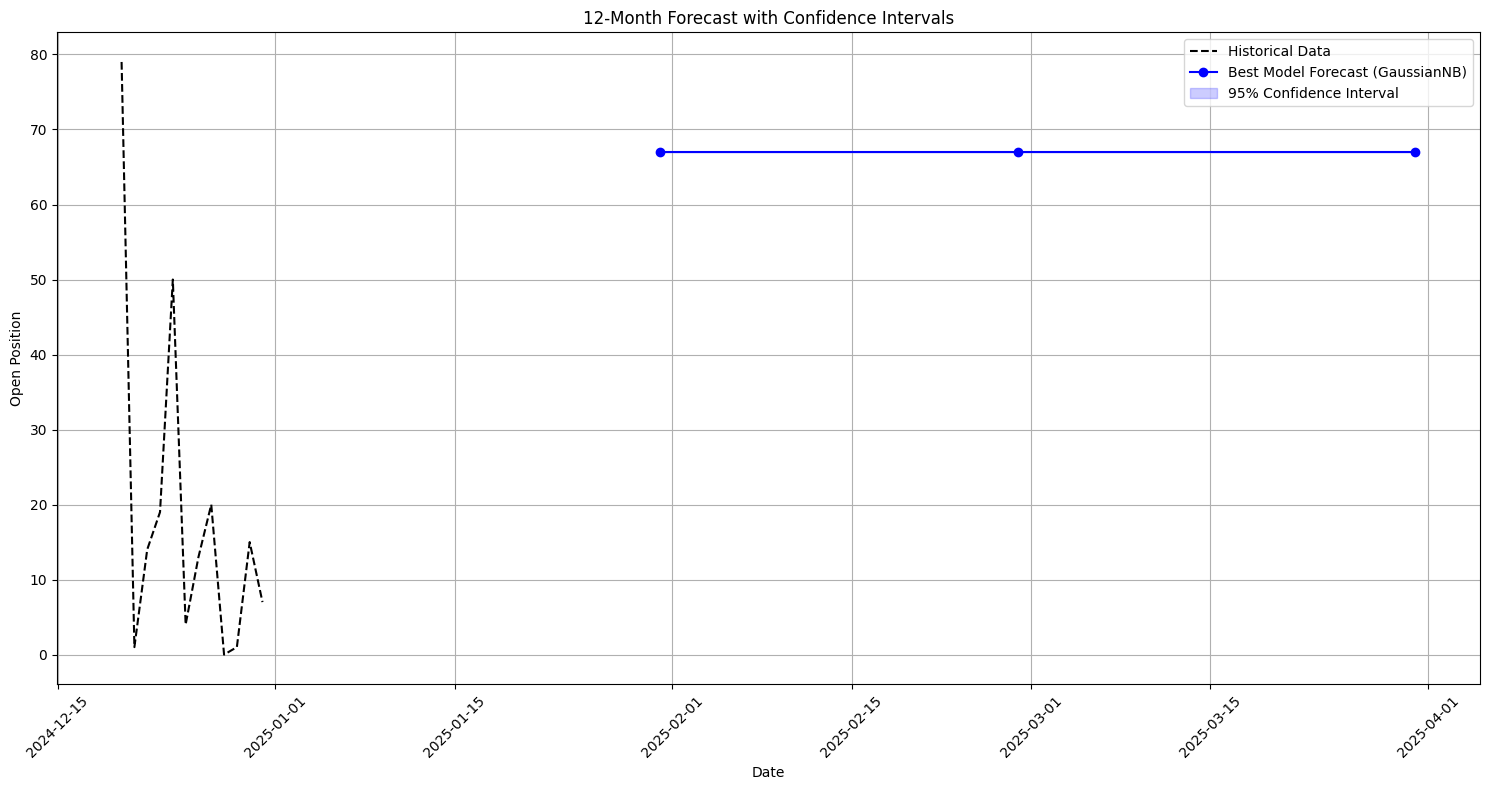


Best Model (GaussianNB) Forecast with 95% Confidence Intervals:
            Forecast  Lower CI  Upper CI
2025-01-31        67      67.0      67.0
2025-02-28        67      67.0      67.0
2025-03-31        67      67.0      67.0


In [40]:
# Get the last sequence from your training data
last_known_sequence = X[-1]

# Create dictionary to store forecasts from different models
forecasts = {}

# Generate forecasts for each model
for name, model in models.items():
    future_predictions = forecast_next_n_months(model, last_known_sequence)
    forecasts[name] = future_predictions

# Create future dates for plotting
last_date = tdf1.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_period + 1, freq='M')[1:]

# Visualize the forecasts
plt.figure(figsize=(15, 8))
# Plot historical data
plt.plot(tdf1.index[-12:], tdf1['Total'].values[-12:], 
         label='Historical Data', color='black', linestyle='--')

# Plot forecasts from each model
for name, forecast in forecasts.items():
    plt.plot(future_dates, forecast, label=f'{name} Forecast', marker='o')

plt.title(f'{forecast_period}-Month Forecast from Different Models')
plt.xlabel('Date')
plt.ylabel('Open Position')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a DataFrame with the forecasts
forecast_df = pd.DataFrame(forecasts, index=future_dates)
print(f"\nForecasted values for next {forecast_period} months:")
print(forecast_df.round(2))

# Calculate confidence intervals for the best performing model
# Using the model with lowest RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_forecast = forecasts[best_model_name]

# Bootstrap to calculate confidence intervals
n_bootstrap = 1000
bootstrap_predictions = np.zeros((n_bootstrap, forecast_period))

for i in range(n_bootstrap):
    # Sample with replacement from the training error distribution
    train_predictions = models[best_model_name].predict(X_train)
    error_distribution = y_train - train_predictions
    sampled_errors = np.random.choice(error_distribution, size=forecast_period)
    bootstrap_predictions[i] = best_forecast + sampled_errors

# Calculate 95% confidence intervals
lower_ci = np.percentile(bootstrap_predictions, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_predictions, 97.5, axis=0)

# Plot forecast with confidence intervals
plt.figure(figsize=(15, 8))
plt.plot(tdf1.index[-12:], tdf1['Total'].values[-12:], 
         label='Historical Data', color='black', linestyle='--')
plt.plot(future_dates, best_forecast, 
         label=f'Best Model Forecast ({best_model_name})', color='blue', marker='o')
plt.fill_between(future_dates, lower_ci, upper_ci, 
                 color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('12-Month Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Open Position')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print forecast with confidence intervals
print(f"\nBest Model ({best_model_name}) Forecast with 95% Confidence Intervals:")
ci_df = pd.DataFrame({
    'Forecast': best_forecast,
    'Lower CI': lower_ci,
    'Upper CI': upper_ci
}, index=future_dates)
print(ci_df.round(2))

In [ ]:
model = AutoTS(
    forecast_length=30,
    frequency='D',
    prediction_interval=0.95,
    ensemble=None, # type: ignore
    models_mode='deep',
    model_list = ['ARIMA'],
    max_generations=10,
    num_validations=3,
    no_negatives=True,
    n_jobs='auto') # type: ignore

In [ ]:
model.fit(tdf1) #type: ignore
prediction = model.predict(forecast_length=30) #type: ignore

In [ ]:
model.export_template(
    "model2.csv",
    models="best",
    max_per_model_class=1,
    include_results=True,
) # type: ignore

In [ ]:
#declare the AutoTS object "model" first
model = model.import_template(
    "model.csv",
    method="only",
    enforce_model_list=True,
)
model.fit(tdf) # type: ignore
prediction = model.predict(forecast_length=10) # type: ignore

In [ ]:
fig,ax = plt.subplots(figsize=(20,3))
ax.plot(tdf1)
ax.plot(prediction.forecast) # type: ignore

In [ ]:
# Fit auto_arima model
auto_model = pm.auto_arima(tdf1, 
                           seasonal=True, m=4, 
                           trace=True, error_action='ignore', 
                           suppress_warnings=True,
                           scoring='mse',
                        #    start_p=0,start_q=0,
                        #    max_p=5,
                        #    max_q=5,
                        #    max_P=2, 
                        #    max_Q=2,
                        #    max_order=5,
                           n_jobs=-1,
                           test='adf',
                           n_fits=50)

# Print the summary of the model
print(auto_model.summary())

In [ ]:
# Predict for the next 3 months (approximately 90 days)
n_periods = 30
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Create a date range for the forecast
forecast_index = pd.date_range(start=tdf.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')

# Create a DataFrame to hold the forecast and confidence intervals
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_index)

forecast_df.to_csv("predict.csv")

# Plot the forecast
fig,ax = plt.subplots(figsize=(20,3))
#plt.figure(figsize=(16, 8))
plt.plot(tdf1, label='Observed')
plt.plot(forecast_df['Forecast'], label='Forecast', color='r')
ax.plot(prediction.forecast)
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Forecast for the next 30 Days')
plt.legend()
plt.show()

In [ ]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#decomposition = seasonal_decompose(timeseries, period = int(len(tdf)/2), model = "additive")  
#figure = plt.figure()  
#figure = decomposition.plot()  
#figure.set_size_inches(15, 8
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model ='additive',extrapolate_trend='freq', period=4)
    fig = decomposition.plot()
    fig.set_size_inches(24,8)
    plt.show()

In [ ]:
seasonal_decompose(tdf)

In [ ]:
#plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    timeseries.rolling(4).mean().plot(label='4 Weeks Rolling Mean')
    timeseries.rolling(8).std().plot(label='8 Weeks Rolling Std')
    timeseries.plot(title=title)
    plt.legend()

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(tdf,'raw data')

In [ ]:
from statsmodels.tsa.stattools import adfuller

"""
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

    for value,label in zip(test_result,labels):
        print(label)
        print(value)
        #print (value)
    if test_result [1] <= 0.05:
        print ("Reject null hypothesis and data is stationary")
    else:
        print ("Fail to reject H0 thereby data is non-stationary ")
"""
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    test_result = adfuller(timeseries.dropna(),autolag='AIC')
    print ('ADF Test:')
    print('Test statistic = {:.3f}'.format(test_result[0]))
    print('P-value = {:.3f}'.format(test_result[1]))
    print('Critical values :')
    for k, v in test_result[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test_result         [0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(tdf,'raw data')

In [ ]:
# Detrending
tdf_detrend =  (tdf - tdf.rolling(window=7).mean())/tdf.rolling(window=7).std()
test_stationarity(tdf_detrend,'de-trended data')
ADF_test(tdf_detrend,'de-trended data')

In [ ]:
# Differencing
tdf_4lag =  tdf - tdf.shift(1)

test_stationarity(tdf_4lag,'4 lag differenced data')
ADF_test(tdf_4lag,'4 lag differenced data')

In [ ]:
# Detrending + Differencing
tdf_4lag_detrend =  tdf_detrend - tdf_detrend.shift(4)
test_stationarity(tdf_4lag_detrend,'4 lag differenced de-trended data')
ADF_test(tdf_4lag_detrend,'4 lag differenced de-trended data')

In [ ]:
y_to_train = tdf_4lag[:'2024-11-01'] # dataset to train
y_to_val = tdf_4lag['2024-11-02':] # last X months for test  
#predict_date = len(tdf_4lag) - len(tdf_4lag[:'2024-12-25']) # the number of data points for the test set
#y_to_val.head()
#y_to_train.head()

In [ ]:
import itertools

def sarima_grid_search(tdf,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(tdf,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(tdf_4lag,12)

In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(15, 12))
    #results.plot_diagnostics()

    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [ ]:
# No need to run this!!!!
model = sarima_eva(y_to_train,(0, 0, 1),(0, 1, 1, 4),4,'2024-12-31',y_to_val)

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [ ]:
model = sm.tsa.statespace.SARIMAX(y_to_train.dropna(),order=(1,0,1), seasonal_order=(1,1,1,12))
ARIMAresult = model.fit()
print (ARIMAresult.summary())

In [ ]:
final_table = forecast(ARIMAresult,60,tdf_4lag)
final_table.head(15)

In [ ]:
PredictionResults = ARIMAresult.predict(1, len(tdf_4lag)+2, typ ='levels').rename('Sarima Predictions')
PredictionResults

In [ ]:
from altair import to_csv
PredictionResults.to_csv("PredictionResults.csv")

In [ ]:
#df['forecast_data'] = ARIMAresult.predict(start = 150, end= 168, dynamic= True)
#df [['Total','forecast_data']]. plot (figsize= (12,8))
ARIMAtable = pd.Series(ARIMAresult.fittedvalues, copy=True)
ARIMAresult.fittedvalues

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(tdf_4lag)
plt.plot(PredictionResults)
plt.title('RMSE: %.4f'% np.sqrt(sum((ARIMAtable)**2)/len(tdf)))

In [ ]:
# Auto ARIMA
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries,
                              start_p = 0,
                              start_q = 0,
                              start_d = 0,
                              max_d = 8,
                              max_p = 8,
                              max_q = 8,
                              test = 'adf',
                              start_P = 0,
                              start_Q = 0,
                              start_D = 0,
                              max_P = 8,
                              max_Q = 8,
                              max_D = 8,
                              stepwise= True,
                              seasonal = True,
                              trace = True,
                              m=12)
    return automodel

In [ ]:
arimamodel(tdf)

In [ ]:
import pickle
pickle.dump(ARIMAresult, open('model.pkl','wb'))

In [ ]:
print(pm.auto_arima(tdf.dropna(),seasonal=True, m=12, test = 'adf').summary())

In [ ]:
x = len(tdf)*(80/100)
x

In [ ]:
y_to_train = tdf.iloc[:(int)(len(df)*(80/100))]
y_to_val = tdf.iloc[:(int)(len(df)*(20/100))]

In [ ]:
model = sm.tsa.statespace.SARIMAX(tdf.dropna(),order=(3,3,0), seasonal_order=(0,0,0,12))

In [ ]:
results = model.fit()

In [ ]:
print(results.summary())

In [ ]:
start = len(y_to_train)

In [ ]:
end = start + len(y_to_val) - 1

In [ ]:
PredictionResults = results.predict(0, len(tdf)+1, typ ='levels').rename('Sarima Predications')

In [ ]:
tdf.plot(legend=True,figsize=(12,8))
PredictionResults[10:].plot(legend=True)

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
error = rmse(y_to_val,PredictionResults)
error